# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

## Settings, Imports and Styles

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams

rcParams.update({
    "figure.figsize": (15, 10),
    "font.size": 14
})

## Preparing data

In [46]:
import json 
from pathlib import Path

import requests


vk_token = Path('access_token.txt').read_text().rstrip()

url = f"https://api.vk.com/method/wall.get?access_token={str(vk_token)}&v=5.92&domain=skillbox_education"


def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

def get_posts():
    all_posts = []
    offset = 0
    count = 100
    while True:
        posts_url = f"{url}&offset={offset}&count={count}"
        response = getjson(posts_url)
        try:
            response = response["response"]
        except KeyError:
            print(response)
            raise
        try:
            posts = response["items"]
        except:
            print(list(response["response"].keys()))
            raise
        
        all_posts.extend(posts)
        
        if len(posts) < count:
            break

        offset += count

    return all_posts


posts_file = Path("posts.json")
if not posts_file.exists():
    posts = get_posts()

    with posts_file.open('w') as f:
        json.dump(posts, f)
else:
    with posts_file.open() as f:
        posts = json.load(f)


In [47]:
from pprint import pprint

print(len(posts))
pprint(posts[0])

3198
{'attachments': [{'link': {'caption': 'skillbox.ru',
                           'description': 'Берём валидатор, подключаем хинтер '
                                          'и запасаемся терпением… Главное, не '
                                          'перепутать последовательность!',
                           'is_favorite': False,
                           'photo': {'album_id': -26,
                                     'date': 1604332843,
                                     'has_tags': False,
                                     'id': 457311037,
                                     'owner_id': 2000058464,
                                     'sizes': [{'height': 480,
                                                'type': 'k',
                                                'url': 'https://sun1-85.userapi.com/c857024/v857024645/19896c/9XDKbqBmEkI.jpg',
                                                'width': 1024},
                                               {'height': 

In [48]:
import re
from datetime import datetime

def get_features(item):
    zero_count = {"count": 0}

    date = datetime.fromtimestamp(item["date"])
    return {
        "text": item["text"],
        "words": len(re.split(r'\s', item["text"])),
        "date": date,
        "year": date.year,
        "month": date.month,
        "day": date.isoweekday(),
        "hour": date.hour,
        "tags": re.findall(r"(#\w+)", item["text"]),
        "attachments": len(item.get("attachments", [])),
        "reposts": item.get("reposts", zero_count)["count"],
        "comments": item.get("comments", zero_count)["count"],
        "likes": item.get("likes", zero_count)["count"],
        "views": item.get("views", zero_count)["count"],

    }

main = pd.DataFrame.from_records([get_features(post) for post in posts])
main

,text,words,date,year,month,day,hour,tags,attachments,reposts,comments,likes,views
0,"Главный закон веб-разработки: “То, что выгляди...",30,2020-11-02 19:00:34,2020,11,1,19,"[#Статья_Skillbox, #Skillbox_Программирование]",1,5,11,57,33449
1,"У диджитал-эпохи много плюсов, всех не перечис...",57,2020-11-02 17:27:49,2020,11,1,17,[#В_Закладки_Skillbox],10,55,16,321,49240
2,Придумали лекарство от грусти в самый хмурый м...,59,2020-11-02 14:06:45,2020,11,1,14,[#Расписание_Skillbox],3,7,2,76,29252
3,2020 год заставил бренды подстраиваться под но...,85,2020-10-31 16:31:33,2020,10,6,16,[#Skillbox_Дизайн],4,3,4,42,24134
4,"А что, если бы злодеи из фильмов ужасов записа...",34,2020-10-30 11:45:39,2020,10,5,11,[#Хэллоуин_Skillbox],9,3,12,104,30768
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,#internetmarketing #business #skillbox\n\n15 с...,246,2016-04-03 14:10:10,2016,4,7,14,"[#internetmarketing, #business, #skillbox]",1,0,0,4,0
3194,#internetmarketing #business #skillbox\n\nБлес...,12,2016-04-02 19:04:13,2016,4,6,19,"[#internetmarketing, #business, #skillbox]",2,0,0,1,0
3195,#movie #internetmarketing #business #skillbox ...,106,2016-04-02 14:05:19,2016,4,6,14,"[#movie, #internetmarketing, #business, #skill...",1,0,0,3,0
3196,#studio #business #skillbox \n\n4 вида рекламн...,106,2016-04-01 15:50:13,2016,4,5,15,"[#studio, #business, #skillbox]",1,0,0,6,0


## Research

In [49]:
main.describe(datetime_is_numeric=True)

,words,date,year,month,day,hour,attachments,reposts,comments,likes,views
count,3198.000000,3198,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3.198000e+03
mean,66.979987,2018-10-18 11:50:19.718574080,2018.287367,6.610069,3.537836,15.224515,1.716073,7.403377,5.815197,58.511570,1.158410e+04
min,1.000000,2016-04-01 11:38:31,2016.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,32.000000,2018-04-30 13:10:03.500000,2018.000000,4.000000,2.000000,12.000000,1.000000,1.000000,0.000000,18.000000,5.282750e+03
50%,54.000000,2018-12-14 13:00:03,2018.000000,7.000000,3.000000,15.000000,1.000000,3.000000,1.000000,35.000000,7.968000e+03
75%,81.000000,2019-08-28 17:25:34.499999744,2019.000000,9.000000,5.000000,18.000000,2.000000,8.000000,6.000000,64.000000,1.336175e+04
max,643.000000,2020-11-02 19:00:34,2020.000000,12.000000,7.000000,23.000000,10.000000,301.000000,802.000000,1847.000000,1.744059e+06
std,61.967276,NaN,1.259175,3.156474,1.846547,3.269407,1.819007,16.527336,19.043107,92.201299,3.293057e+04


In [50]:
main.query("views == 0").describe(datetime_is_numeric=True)

,words,date,year,month,day,hour,attachments,reposts,comments,likes,views
count,515.000000,515,515.0,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.0
mean,80.085437,2016-07-04 23:04:41.559223296,2016.0,6.603883,3.638835,14.419417,1.477670,3.089320,0.429126,33.722330,0.0
min,1.000000,2016-04-01 11:38:31,2016.0,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,10.000000,2016-05-17 12:05:57.500000,2016.0,5.000000,2.000000,11.000000,1.000000,0.000000,0.000000,6.000000,0.0
50%,33.000000,2016-06-21 10:15:04,2016.0,6.000000,4.000000,15.000000,1.000000,1.000000,0.000000,10.000000,0.0
75%,90.000000,2016-08-08 00:55:06.500000,2016.0,8.000000,5.000000,17.000000,2.000000,2.000000,0.000000,17.000000,0.0
max,643.000000,2016-12-28 21:04:50,2016.0,12.000000,7.000000,22.000000,9.000000,264.000000,34.000000,1847.000000,0.0
std,113.667036,NaN,0.0,2.183771,1.868656,3.274535,0.681171,15.084063,1.982493,126.940144,0.0


In [51]:
main.isna().sum()

text           0
words          0
date           0
year           0
month          0
day            0
hour           0
tags           0
attachments    0
reposts        0
comments       0
likes          0
views          0
dtype: int64

In [52]:
monthly = main.resample("M", on="date")

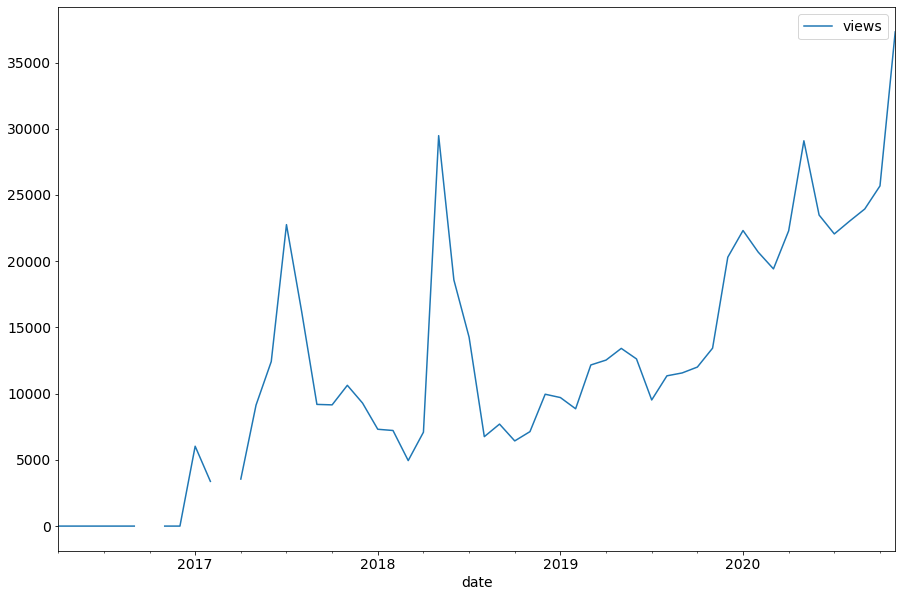

In [53]:
monthly[["views"]].mean().plot()

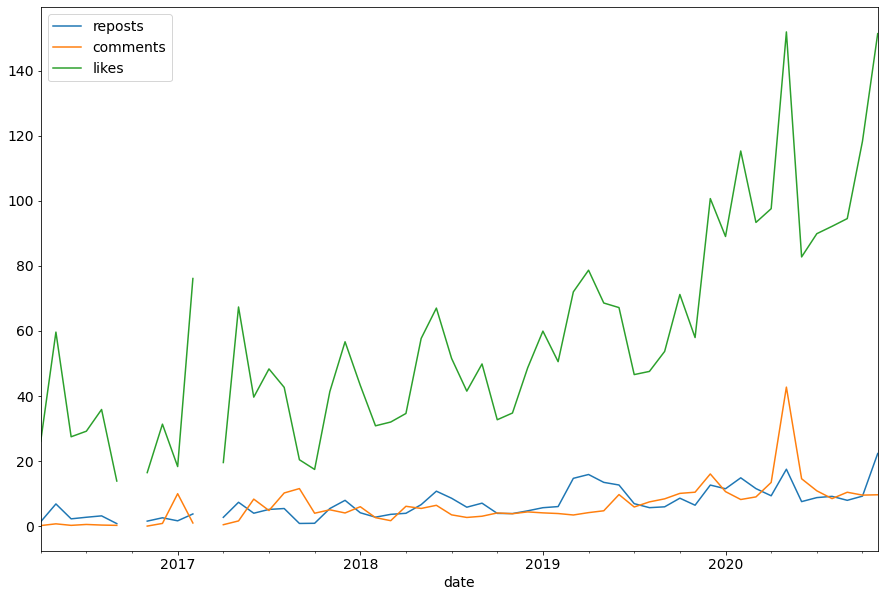

In [54]:
monthly[["reposts", "comments", "likes"]].mean().plot()

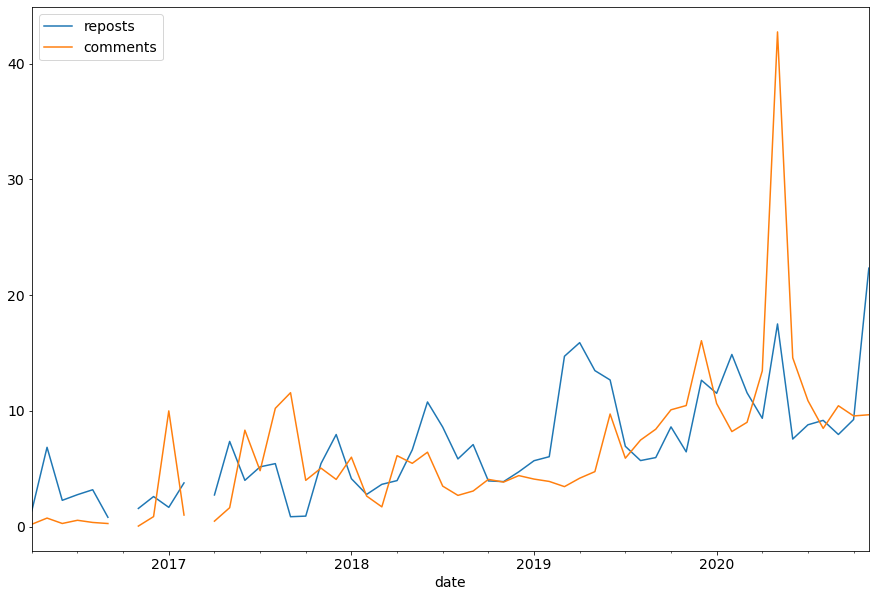

In [55]:
monthly[["reposts", "comments"]].mean().plot()

Глядя на этот график, можно сделать вывод, что для пользователя вконтакта репост и коммент по затратам энернии примерно одинаковы. 

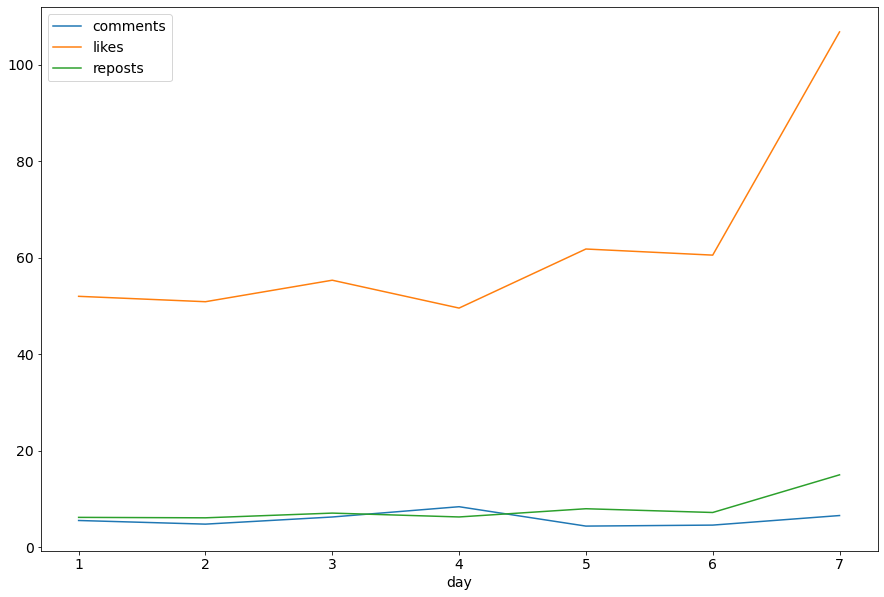

In [56]:
main.pivot_table(
    index=["day"],
    aggfunc={
        # "views": "mean", 
        "comments": "mean", 
        "reposts": "mean",
        "likes": "mean"
    }
).plot()

По воскресеньям народ активнее. 

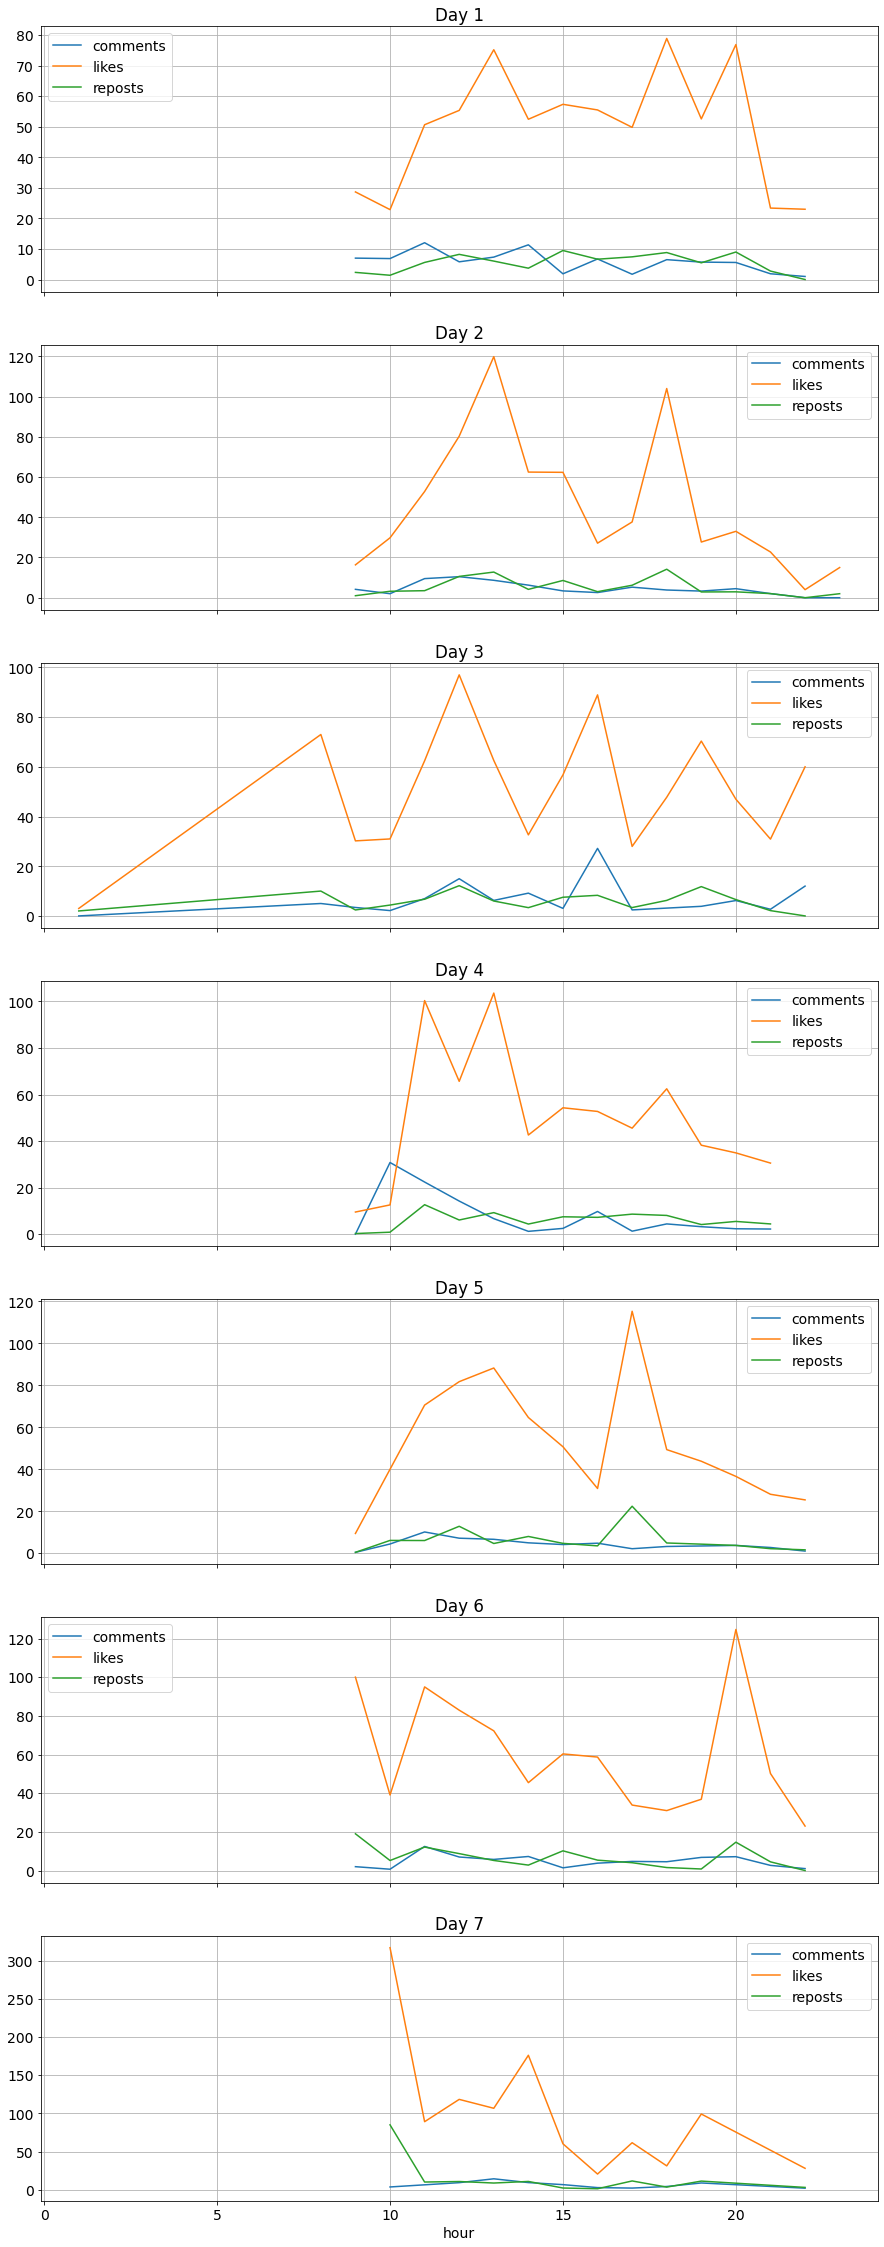

In [57]:
groups = main.groupby("day")
fig, axs = plt.subplots(len(groups), 1, figsize=(15, 40), sharex=True)

for (name, group), ax in zip(groups, axs.flat):
    by_hour = group.pivot_table(
        index=["hour"],
        values=["comments", "reposts", "likes"],
        aggfunc="mean",
    )
    # by_hour_max = group.pivot_table(
    #     index=["hour"],
    #     values=["comments", "reposts", "likes"],
    #     aggfunc="max",
    # )
    # (by_hour / by_hour_max).plot.bar(ax=ax, title=f"Day {name}", rot=0)
    by_hour.plot(ax=ax, title=f"Day {name}", rot=0)
    ax.grid(True)

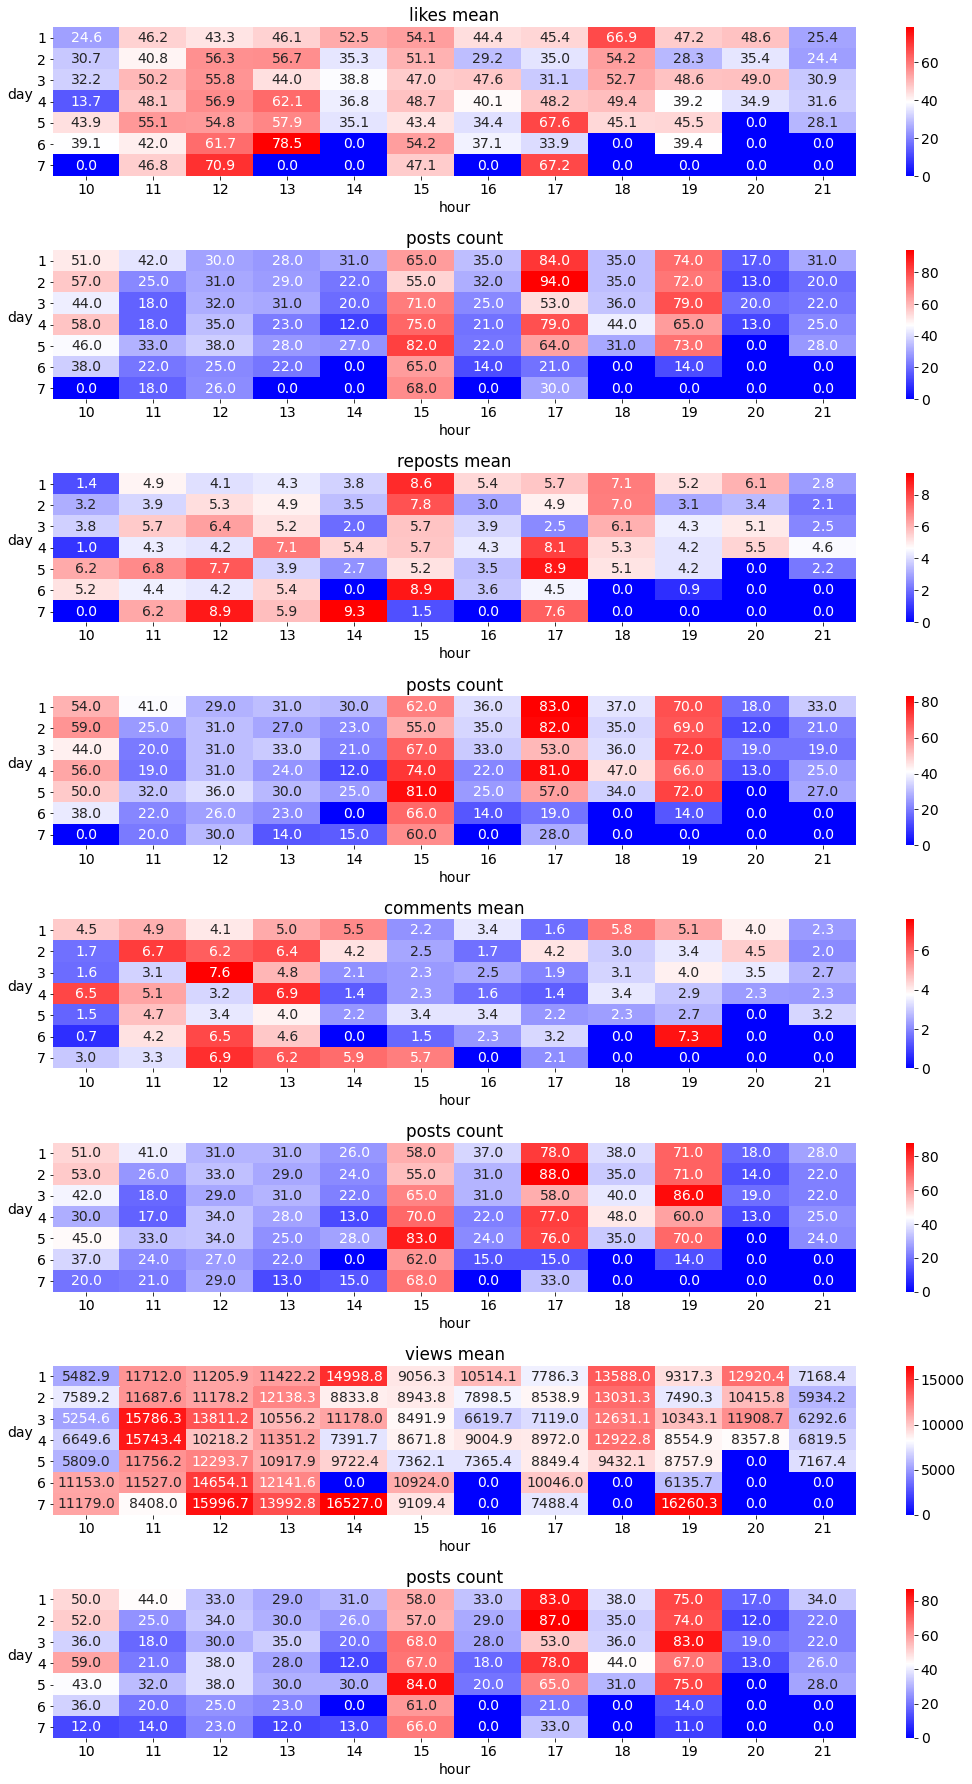

In [58]:
import seaborn as sns
from itertools import product

count = None

dimensions = list(product(["likes", "reposts", "comments", "views"], ["mean", "count"]))
fix, axs = plt.subplots(len(dimensions), 1, figsize=(15, 25))
for (dim, agg), ax in zip(dimensions, axs.flat):
    
    # Clean up spikes.
    working = main.copy().sort_values(dim)
    cut = int(len(working) * 0.05)
    working = working[cut:-cut]

    if agg != "count":
        count = working.pivot_table(
            index=["hour"],
            columns=["day"],
            values=dim,
            aggfunc="count",
        )
    
        working = working.pivot_table(
            index=["hour"],
            columns=["day"],
            values=dim,
            aggfunc="mean",
        )
    else:
        working = count

    working = working[count > 10].dropna(how="all").fillna(0.0)
    
    sns.heatmap(working.transpose(), ax=ax, cmap="bwr", annot=True, fmt=".1f")
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)
    plt.setp(ax.yaxis.label, ha="right", rotation=0)

    if agg == "count":
        ax.set_title(f"posts count")
    else:
        ax.set_title(f"{dim} {agg}")

plt.tight_layout()

11, 12 и 18 часов — недооцененное время, надо больше постить в эти часы. Меньше в 17 и 19 в пользу 18.

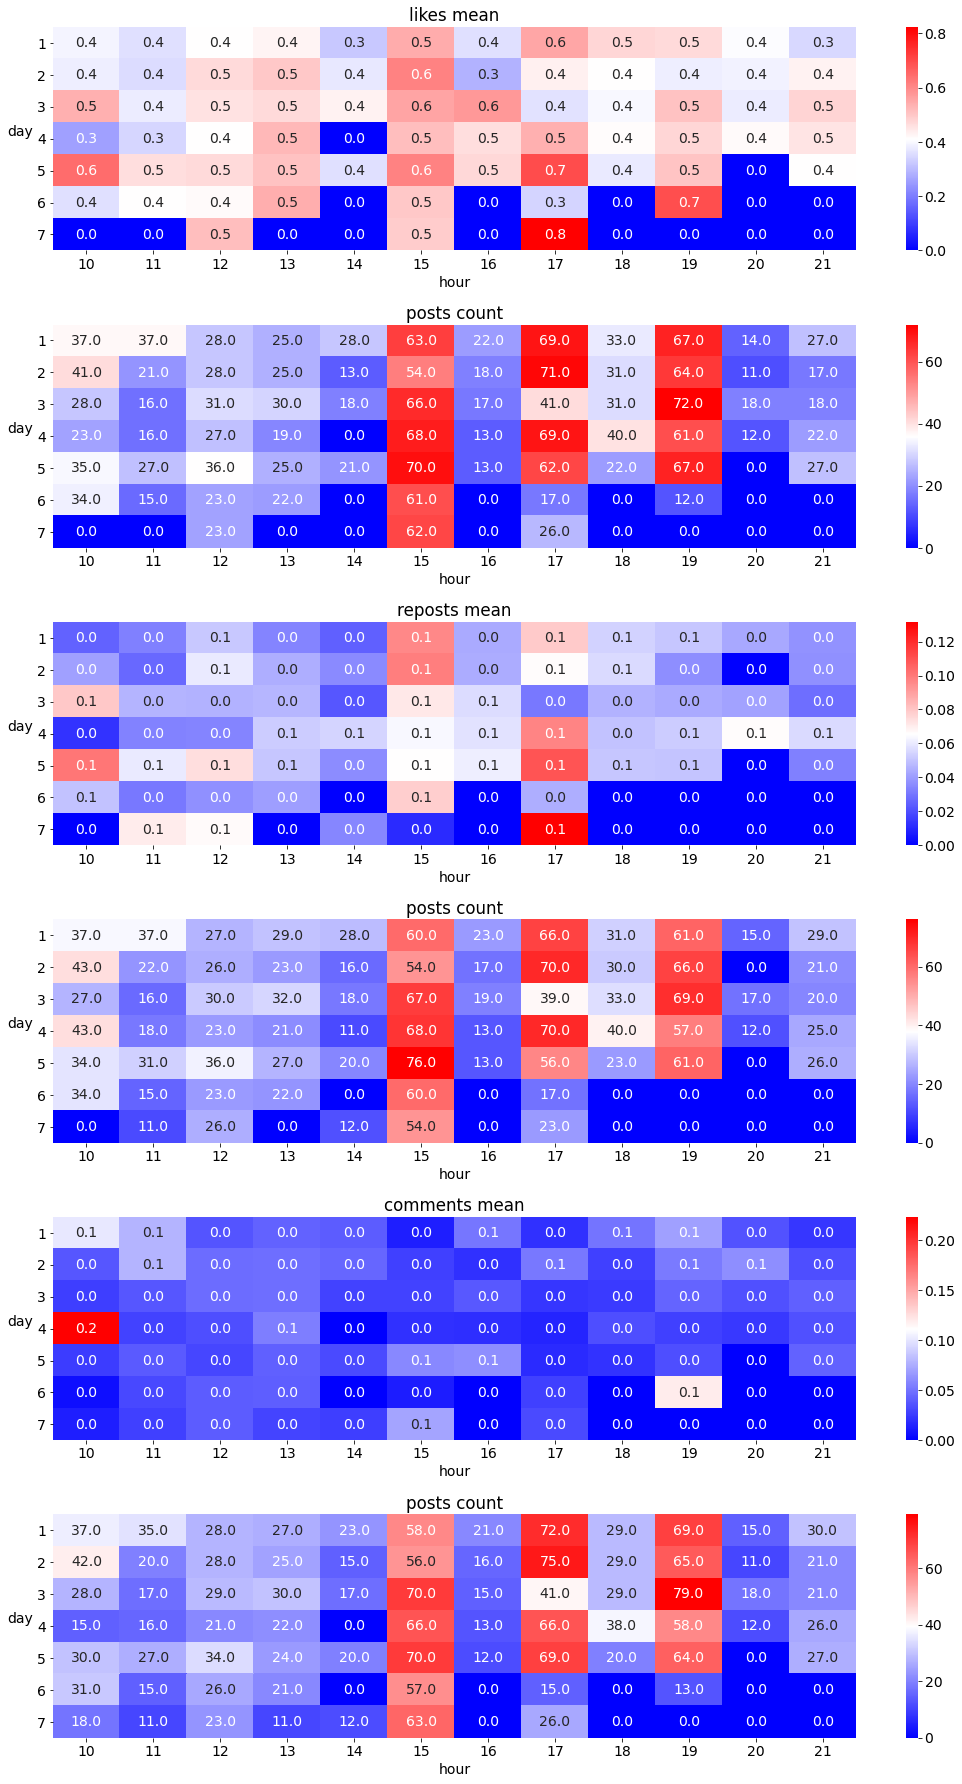

In [59]:
import seaborn as sns
from itertools import product

count = None

fix, axs = plt.subplots(6, 1, figsize=(15, 25))
for (dim, agg), ax in zip(product(["likes", "reposts", "comments"], ["mean", "count"]), axs.flat):
    
    # Clean up spikes.
    working = main.copy().query("views != 0").sort_values(dim)
    cut = int(len(working) * 0.05)
    working = working[cut:-cut]

    if agg != "count":
        count = working.pivot_table(
            index=["hour"],
            columns=["day"],
            values=dim,
            aggfunc="count",
        )
        
        working[dim] = working[dim] / working["views"] * 100
        working = working.pivot_table(
            index=["hour"],
            columns=["day"],
            values=dim,
            aggfunc="mean",
        )
    else:
        working = count

    working = working[count > 10].dropna(how="all").fillna(0.0)
    
    sns.heatmap(working.transpose(), ax=ax, cmap="bwr", annot=True, fmt=".1f")
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)
    plt.setp(ax.yaxis.label, ha="right", rotation=0)

    if agg == "count":
        ax.set_title(f"posts count")
    else:
        ax.set_title(f"{dim} {agg}")

plt.tight_layout()

In [60]:
main.eval(
    """
    reposts_conv = reposts / views
    comments_conv = comments / views
    likes_conv = likes / views
    """, 
    inplace=True
)
main

,text,words,date,year,month,day,hour,tags,attachments,reposts,comments,likes,views,reposts_conv,comments_conv,likes_conv
0,"Главный закон веб-разработки: “То, что выгляди...",30,2020-11-02 19:00:34,2020,11,1,19,"[#Статья_Skillbox, #Skillbox_Программирование]",1,5,11,57,33449,0.000149,0.000329,0.001704
1,"У диджитал-эпохи много плюсов, всех не перечис...",57,2020-11-02 17:27:49,2020,11,1,17,[#В_Закладки_Skillbox],10,55,16,321,49240,0.001117,0.000325,0.006519
2,Придумали лекарство от грусти в самый хмурый м...,59,2020-11-02 14:06:45,2020,11,1,14,[#Расписание_Skillbox],3,7,2,76,29252,0.000239,0.000068,0.002598
3,2020 год заставил бренды подстраиваться под но...,85,2020-10-31 16:31:33,2020,10,6,16,[#Skillbox_Дизайн],4,3,4,42,24134,0.000124,0.000166,0.001740
4,"А что, если бы злодеи из фильмов ужасов записа...",34,2020-10-30 11:45:39,2020,10,5,11,[#Хэллоуин_Skillbox],9,3,12,104,30768,0.000098,0.000390,0.003380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,#internetmarketing #business #skillbox\n\n15 с...,246,2016-04-03 14:10:10,2016,4,7,14,"[#internetmarketing, #business, #skillbox]",1,0,0,4,0,NaN,NaN,inf
3194,#internetmarketing #business #skillbox\n\nБлес...,12,2016-04-02 19:04:13,2016,4,6,19,"[#internetmarketing, #business, #skillbox]",2,0,0,1,0,NaN,NaN,inf
3195,#movie #internetmarketing #business #skillbox ...,106,2016-04-02 14:05:19,2016,4,6,14,"[#movie, #internetmarketing, #business, #skill...",1,0,0,3,0,NaN,NaN,inf
3196,#studio #business #skillbox \n\n4 вида рекламн...,106,2016-04-01 15:50:13,2016,4,5,15,"[#studio, #business, #skillbox]",1,0,0,6,0,NaN,NaN,inf


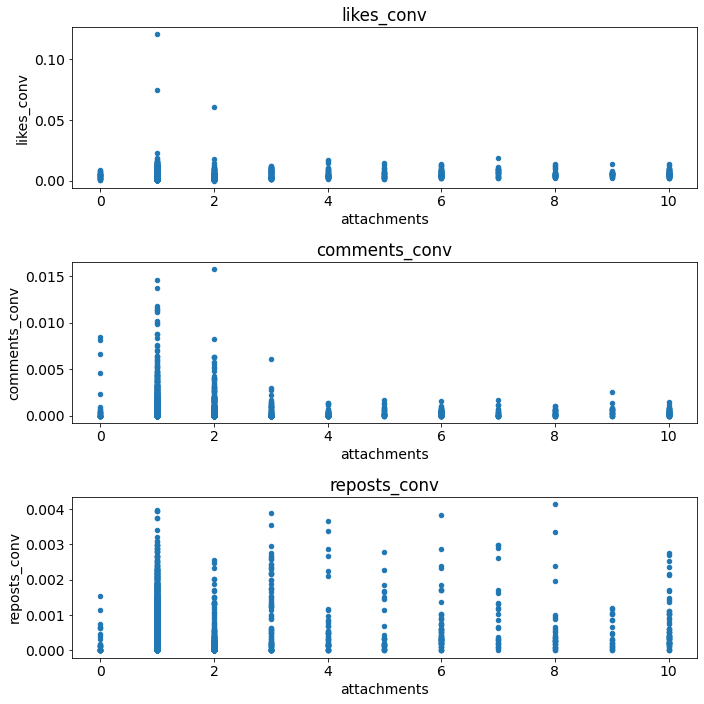

In [61]:
fix, axs = plt.subplots(3, 1, figsize=(10, 10))

for dim, ax in zip(["likes_conv", "comments_conv", "reposts_conv"], axs.flat):
    main.plot.scatter(x="attachments", y=dim, ax=ax, title=dim)

plt.tight_layout()

Отсутствие картинки ограничивает конверсию поста в лайки, репосты и комменты.

## Влияет ли текст поста на конверсию?

Количество слов в посте слабо влияет на конверсибю в лайк. Разве что посты с количеством слов больше 150 (на глаз) конвертятся несколбко хуже. И данных по ним мало.

In [62]:
import nltk

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mgserjio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [63]:
main.year.value_counts()

2018    1033
2019     988
2020     541
2016     515
2017     121
Name: year, dtype: int64

In [64]:
posts = (
    main
    .query("(year >= 2018)")
    .query("((hour == 12) | (hour == 13) | (hour == 15) | (hour == 19))")
)
posts.tags = posts.tags.transform(tuple)

# posts.tags.value_counts().head(50)
posts

# posts.groupby("tags")[["tags", "likes"]].mean().sort_values("likes", ascending=False).head(60)

,text,words,date,year,month,day,hour,tags,attachments,reposts,comments,likes,views,reposts_conv,comments_conv,likes_conv
0,"Главный закон веб-разработки: “То, что выгляди...",30,2020-11-02 19:00:34,2020,11,1,19,"(#Статья_Skillbox, #Skillbox_Программирование)",1,5,11,57,33449,0.000149,0.000329,0.001704
6,У фотографов муза — ну очень капризная!\n\nОна...,66,2020-10-29 12:13:54,2020,10,4,12,"(#Конкурс,)",9,31,0,171,25581,0.001212,0.000000,0.006685
10,Бумага все стерпит. А еще она разовьет ваши тв...,51,2020-10-27 13:31:02,2020,10,2,13,"(#В_Закладки_Skillbox,)",10,33,11,246,32377,0.001019,0.000340,0.007598
11,Сектор «День рождения» на барабане!\n\n26 октя...,110,2020-10-26 19:07:38,2020,10,1,19,"(#Поле_чудес,)",6,6,11,112,22496,0.000267,0.000489,0.004979
14,Добавить бумажной книге интерактивные функции?...,97,2020-10-24 12:48:53,2020,10,6,12,"(#Новости_Skillbox, #Skillbox_программирование)",1,3,9,44,23433,0.000128,0.000384,0.001878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556,Всем привет!\nСегодня в 16:00 по Москве состои...,49,2018-01-26 15:30:02,2018,1,5,15,(),2,2,10,22,5628,0.000355,0.001777,0.003909
2557,"Привет! Вы знаете, какой самый надёжный путь д...",43,2018-01-24 15:35:38,2018,1,3,15,(),2,13,1,77,6893,0.001886,0.000145,0.011171
2558,Привет всем!\nМы готовы с новыми силами присту...,45,2018-01-22 12:01:24,2018,1,1,12,(),1,0,2,22,7248,0.000000,0.000276,0.003035
2560,Привет! Сегодня у нас очень крутой мастер-клас...,36,2018-01-17 15:27:00,2018,1,3,15,(),2,9,2,96,9534,0.000944,0.000210,0.010069


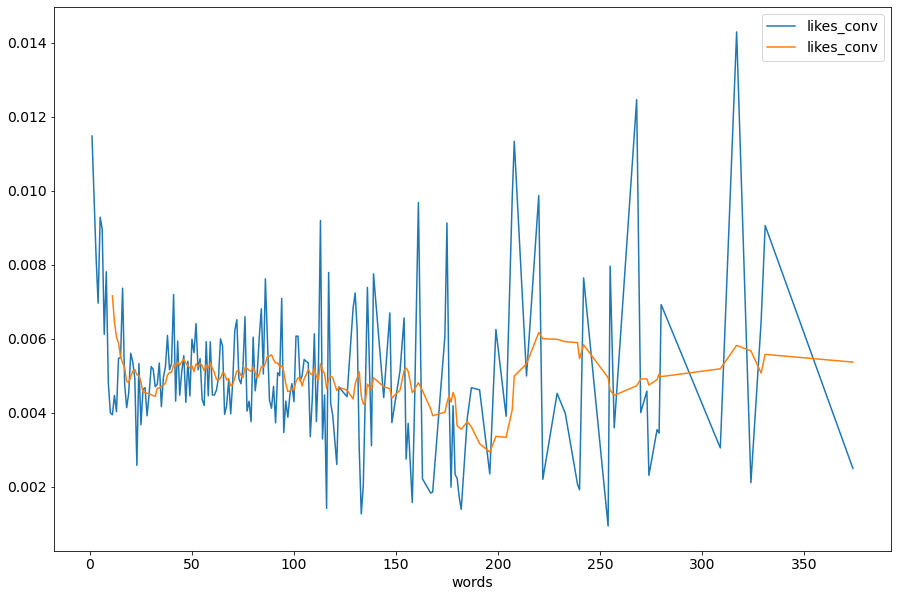

In [65]:
working = (
    posts
    .query("(views > 0)")
    .sort_values("likes_conv")
    .pivot_table(
        index="words",
        values=["likes_conv"],
        aggfunc="mean"
    )
)

ax = working.plot()
working.rolling(10).mean().plot(ax=ax)

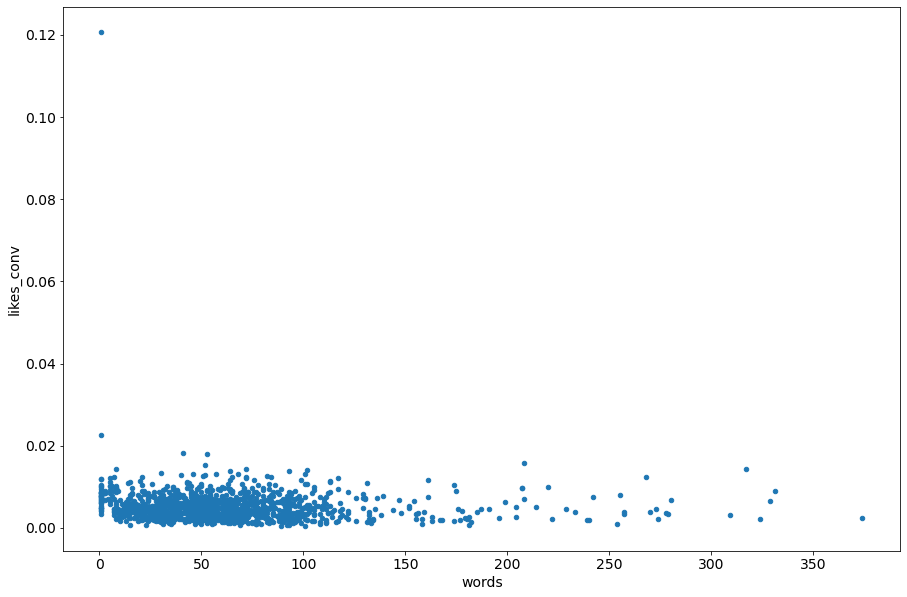

In [66]:
posts.plot.scatter(x="words", y="likes_conv")

In [67]:
from collections import Counter

mystem = Mystem()
russian_stopwords = stopwords.words("russian")

number_of_words_to_consider = 30

def get_words(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [
        token for token in
        tokens if token not in russian_stopwords and token.isalnum()
            # and token != " " 
            # and token.strip() not in punctuation
        ]
    
    return sorted(tokens[:number_of_words_to_consider])


def word_stats(posts):
    total = Counter()
    documents = Counter()

    stems = posts.text.apply(get_words)

    for l in stems:
        for w in l:
            total[w] += 1
        for w in set(l):
            documents[w] += 1

    words = pd.DataFrame(
        [(k, v, documents[k]) for k, v in total.items()], 
        columns=["words", "total_count", "document_count"]
    ).set_index("words")

    words["density"] = words.document_count / len(posts)

    return words.sort_values(by=["total_count", "document_count"], ascending=False)




In [68]:
words = word_stats(posts)

In [69]:
likes_conv_mean = posts.likes_conv.mean()
likes_conv_std = posts.likes_conv.std()
likes_conv_mean, likes_conv_std

(0.0052528600415640125, 0.004339593344159088)

In [70]:
high_conv_posts = posts.query("likes_conv >= @likes_conv_mean + 0.5 * @likes_conv_std")
low_conv_posts = posts.query("likes_conv <= @likes_conv_mean")

In [71]:
words_high = word_stats(high_conv_posts)
words_low = word_stats(low_conv_posts)

In [72]:
words_high.sort_values(by="density", ascending=False).head(20)

,total_count,document_count,density
words,,,
skillbox,111,72,0.318584
который,76,70,0.309735
свой,52,44,0.194690
это,46,38,0.168142
дизайнер,41,36,0.159292
наш,37,36,0.159292
education,57,35,0.154867
дизайн,51,34,0.150442
рассказывать,34,34,0.150442


In [73]:
words_low.sort_values(by="density", ascending=False).head(20)

,total_count,document_count,density
words,,,
skillbox,397,285,0.401408
наш,190,172,0.242254
который,186,169,0.238028
рассказывать,157,146,0.205634
это,163,139,0.195775
свой,143,128,0.180282
новый,127,115,0.161972
education,153,113,0.159155
весь,106,103,0.145070


In [74]:
mean_density = words.density.mean()

words_dens = (
    words_low
    # words
    # .merge(
    #     words_low,
    #     on="words",
    #     suffixes=("", "_low"),
    #     how="left"
    # )
    .merge(
        words_high,
        on="words",
        suffixes=("_low", "_high"),
        how="left"
    )
    .fillna(0.0)
    # [["density", "density_high"]]
    .query("density_low >= @mean_density")
    .query("document_count_low > 15")
    .eval("diff = (density_high - density_low)") 
    # .eval("diff = (density_high - density_low) / @words.density")  #<------------------ Error
)
words_dens.sort_values(by="diff", ascending=False).head(50)


,total_count_low,document_count_low,density_low,total_count_high,document_count_high,density_high,diff
words,,,,,,,
подборка,34,30,0.042254,33.0,32.0,0.141593,0.099339
шрифт,49,23,0.032394,56.0,28.0,0.123894,0.091499
который,186,169,0.238028,76.0,70.0,0.309735,0.071706
помогать,30,29,0.040845,24.0,22.0,0.097345,0.056500
read,64,64,0.090141,33.0,33.0,0.146018,0.055877
собирать,31,30,0.042254,22.0,21.0,0.092920,0.050667
полезный,24,24,0.033803,20.0,19.0,0.084071,0.050268
design,30,28,0.039437,18.0,18.0,0.079646,0.040209
самый,65,64,0.090141,33.0,29.0,0.128319,0.038178


## Выводы и наблюдения

Пользователи вк в утро воскаресенья активнее, чем в любой другой день. Репост и коммент для пользователей примерно равносильны по трудозатратам, а лайк много "дешевле" (С любовью, Ваш Капитан О.). 

Время в которе пост был опубликован очень сильно влияет на конверсию поста в реакцию. Команда SMM отдела Skillbox хорошо выбрала время 15 часов для публикации большей части своих постов. Это время самое лучше по показателю конверсии поста в реакцию. 

Время с 11 по 13 часов оказалось очень недооцененным: на этот промежуток приходится наибольшее количество просмотров, а конверсия в реакцию, хоть и неже, чем в 15 часов, остается на высоком уровне. За счет большого числа просмотров, приходящийся нв этот период, он является самым резултативнам по показателю реакций в абсолютных числах. При этом видно, что команда SMM skillbox отдает предпочтнение 10 часам, при том, что результативность этого времени ниже, чем у промежутка, описанного выше. Думаю, команде стоит пересмотреть распределение постов по времени.

Аналогичная история с 17 и 18 часами. Стоит в начале недели (до среды включительно) отдавать предпочтнение 18 часам, а в середине и в конце — 17. Время 19 часов сильно переоценено. Некоторую часть постов, приходящуюся на это время, стоит перенести на 18 часов.

Отсутствие картинки в посте ограничивает его конверсию в реакции.

Эксперимент с лингвистикой провалился — мне не удалось выделить какой-либо сигнал, говорящий в пользу того, что вординг влияет на коныерсию поста. Опровергнуть эту гипотезу тоже не удалось. Можно было бы обучить регрессоры и пытаться предсказывать конверсию поста по времени публикации и вектору слов в посте. Или собрать много постов из одного временного промежутка и изолированно оценить влияние вординга на конверсию. 




